In [1]:
# Exercise 7-8
# The objective of this exercise is to investigate the relationships between mpg and other feature variables
# in the Auto dset and to look for evidence of non-linear relationships in the data.

In [2]:
rm(list=ls())
library(ISLR)
library(boot)
library(splines)

In [3]:
fix(Auto)
attach(Auto)
nrow(Auto)
summary(Auto)

[1] 392

      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.00   1st Qu.:4.000   1st Qu.:105.0   1st Qu.: 75.0   1st Qu.:2225  
 Median :22.75   Median :4.000   Median :151.0   Median : 93.5   Median :2804  
 Mean   :23.45   Mean   :5.472   Mean   :194.4   Mean   :104.5   Mean   :2978  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:275.8   3rd Qu.:126.0   3rd Qu.:3615  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
                                                                               
  acceleration        year           origin                      name    
 Min.   : 8.00   Min.   :70.00   Min.   :1.000   amc matador       :  5  
 1st Qu.:13.78   1st Qu.:73.00   1st Qu.:1.000   ford pinto        :  5  
 Median :15.50   Median :76.00   Median :1.000   toyota corolla    :  5  
 Mean   :15.54   Mean   :75.98   Mean   :1.577   amc gremlin    

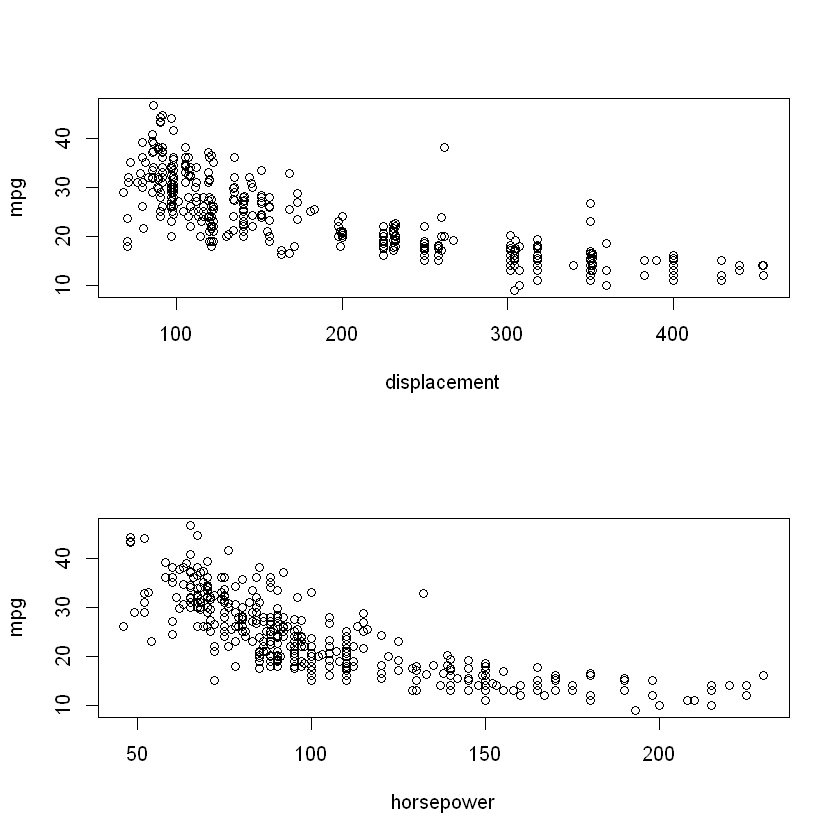

In [4]:
# For the purposes of this exercise, I will focus on mpg as the response variable and displacement
# and horsepower as the predictor variables.
par(mfrow=c(2,1))
plot(displacement, mpg)
plot(horsepower, mpg)
# The below plots for mpg vs. each of displacement and horsepower indicate signs of nonlinear decreasing relationships.  
# For simplicity, I will focus on the polynomial regression and GAM (using splines) methods.

In [5]:
# Here I create the base model: ordinary linear regression of mpg on both feature vars:
m1 <- lm(mpg~displacement+horsepower)
summary(m1)


Call:
lm(formula = mpg ~ displacement + horsepower)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3674  -3.1721  -0.4338   2.3349  16.4288 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37.469488   0.727716  51.489  < 2e-16 ***
displacement -0.040818   0.004963  -8.225 2.95e-15 ***
horsepower   -0.058275   0.013491  -4.319 1.99e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.534 on 389 degrees of freedom
Multiple R-squared:  0.6643,	Adjusted R-squared:  0.6626 
F-statistic: 384.9 on 2 and 389 DF,  p-value: < 2.2e-16


In [6]:
# Lastly, let's fit this OLS as a GLM to use the cv.glm functionality to establish a base level of error:
num_runs <- 10
# Allocate 1D array to hold results:
ols_storage_mat <- matrix(0, nrow=1, ncol=num_runs)
for (k in 1:num_runs)
{
    set.seed(k)
    model <- glm(mpg ~ displacement + horsepower, data=Auto) 
    ols_storage_mat[1, k] <-  cv.glm(data=Auto, glmfit=model, K=10)$delta[1]
}
# print(ols_storage_mat)
print(mean(ols_storage_mat))
ols_error <- mean(ols_storage_mat)

[1] 20.80207


In [7]:
# Nonlinear method 1: polynomial regression.
# For polynomials of order 1-5 for each of the two feature vars, I will loop through and evaluate the CV error
# of each candidate model:
max_deg <- 5
# Create a data structure to store the MSE results:
poly_mse_storage <- rep(0, max_deg^2)
# print(poly_mse_storage)

 [1] 20.66342 17.12867 16.80995 16.94731 16.52553 16.45741 16.11508 16.01246
 [9] 16.32735 15.83315 16.52141 16.22838 16.41727 16.48008 16.02357 16.33121
[17] 16.03063 15.88137 16.39367 15.74028 16.74964 15.61692 16.01321 16.56021
[25] 16.22542


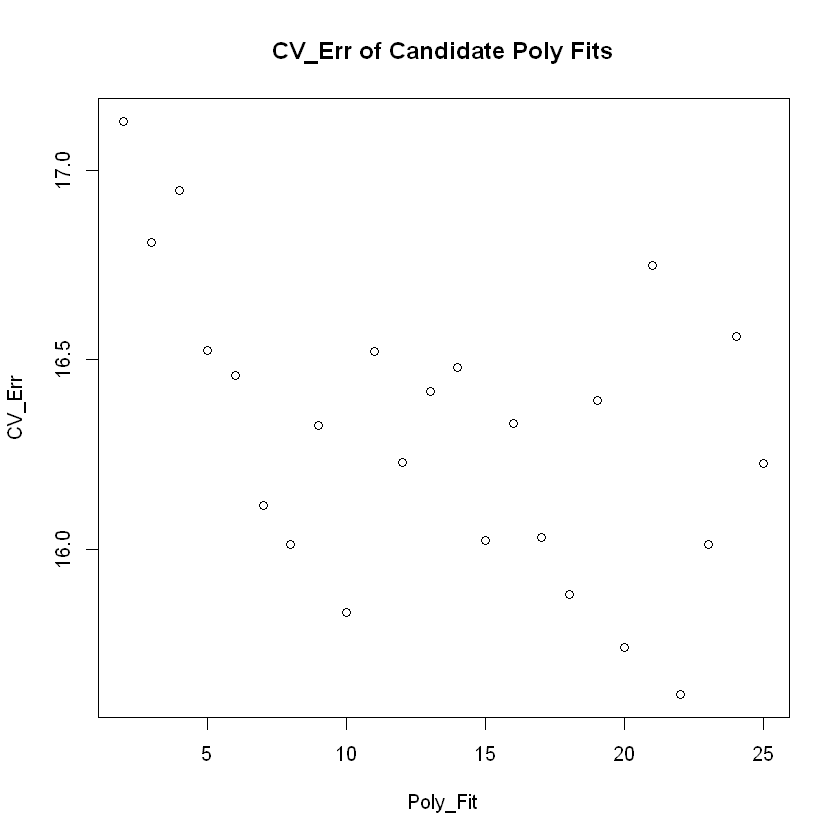

In [8]:
set.seed(1)
for (i in 1:max_deg)
{
    for (j in 1:max_deg)
    {
       model <- glm(mpg ~ poly(displacement,i) + poly(horsepower,j), data=Auto) 
       poly_mse_storage[max_deg*(i-1)+j] <-  cv.glm(data=Auto, glmfit=model, K=10)$delta[1]
    }
}
print(poly_mse_storage)
# Viz MSE results.  As the first candidate (linear fit for both) is so much worse than others, exclude it
# to improve clarity:
plot(2:max_deg^2, poly_mse_storage[2:max_deg^2], xlab="Poly_Fit", ylab="CV_Err", main="CV_Err of Candidate Poly Fits")

In [9]:
print(which.min(poly_mse_storage))
# When setting the seed as 1, the 22nd item is optimal.  Let's try another seed:

[1] 22


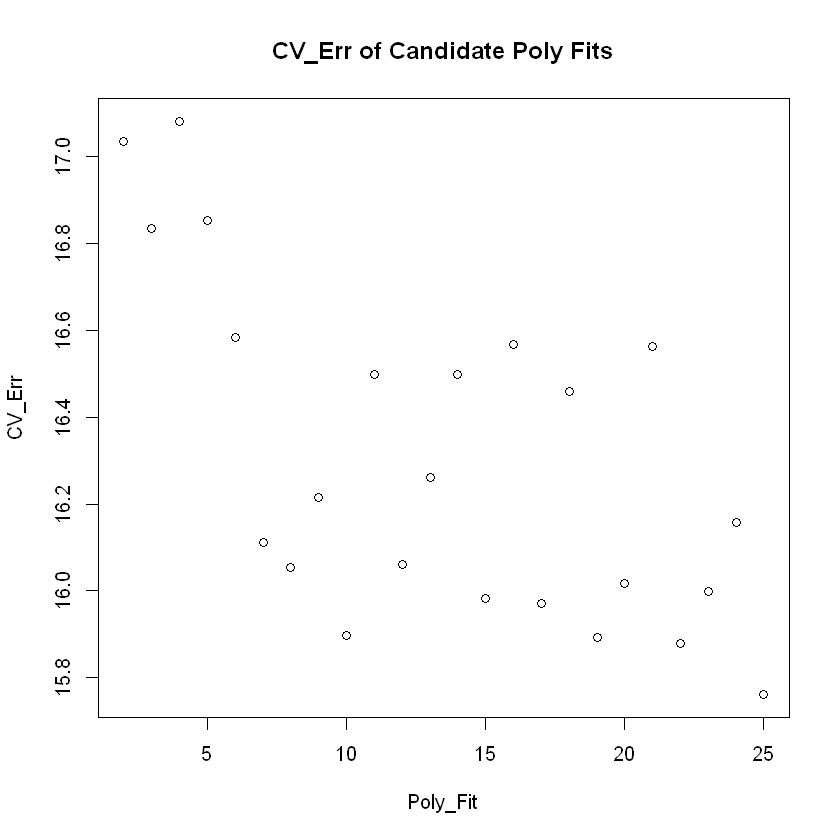

In [10]:
set.seed(2)
for (i in 1:max_deg)
{
    for (j in 1:max_deg)
    {
       model <- glm(mpg ~ poly(displacement,i) + poly(horsepower,j), data=Auto) 
       poly_mse_storage[max_deg*(i-1)+j] <-  cv.glm(data=Auto, glmfit=model, K=10)$delta[1]
    }
}
# Viz MSE results.  As the first candidate (linear fit for both) is so much worse than others, exclude it
# to improve clarity:
plot(2:max_deg^2, poly_mse_storage[2:max_deg^2], xlab="Poly_Fit", ylab="CV_Err", main="CV_Err of Candidate Poly Fits")

In [11]:
print(which.min(poly_mse_storage))
# Now the 25th option looks optimal.  

[1] 25


In [12]:
# One approach would be to CV over the possible choices for K in K-fold CV.  However, for simplicity, I will
# iterate over 10 choices of seed with 10-fold CV, and take the indicated optimal there.
# Parms:
max_deg <- 5
num_runs <- 10
# Allocate 2D array to hold results from all the runs:
poly_mse_storage_mat <- matrix(0, nrow=max_deg^2, ncol=num_runs)
for (k in 1:num_runs)
{
    set.seed(k)
    for (i in 1:max_deg)
    {
        for (j in 1:max_deg)
        {
           model <- glm(mpg ~ poly(displacement,i) + poly(horsepower,j), data=Auto) 
           poly_mse_storage_mat[max_deg*(i-1)+j, k] <-  cv.glm(data=Auto, glmfit=model, K=10)$delta[1]
           # I was using this to troubleshoot previously: print(poly_mse_storage_mat)
        }
    }
}

In [13]:
# Let's look at the output matrix:
head(poly_mse_storage_mat, 3)
nrow(poly_mse_storage_mat)
ncol(poly_mse_storage_mat)
# print(poly_mse_storage_mat)
# Each column = one choice of seed, each row in a col is one combo of powers of the poly.

20.66342,20.78089,20.84346,20.68366,20.78956,20.82469,21.01419,20.97403,20.84403,20.60274
17.12867,17.03482,16.87322,17.14624,17.19297,17.14665,17.39167,16.89519,17.11850,17.19118
16.80995,16.83397,16.88031,16.69890,16.70879,16.82109,16.70969,16.74930,16.64109,16.88616


[1] 25

[1] 10

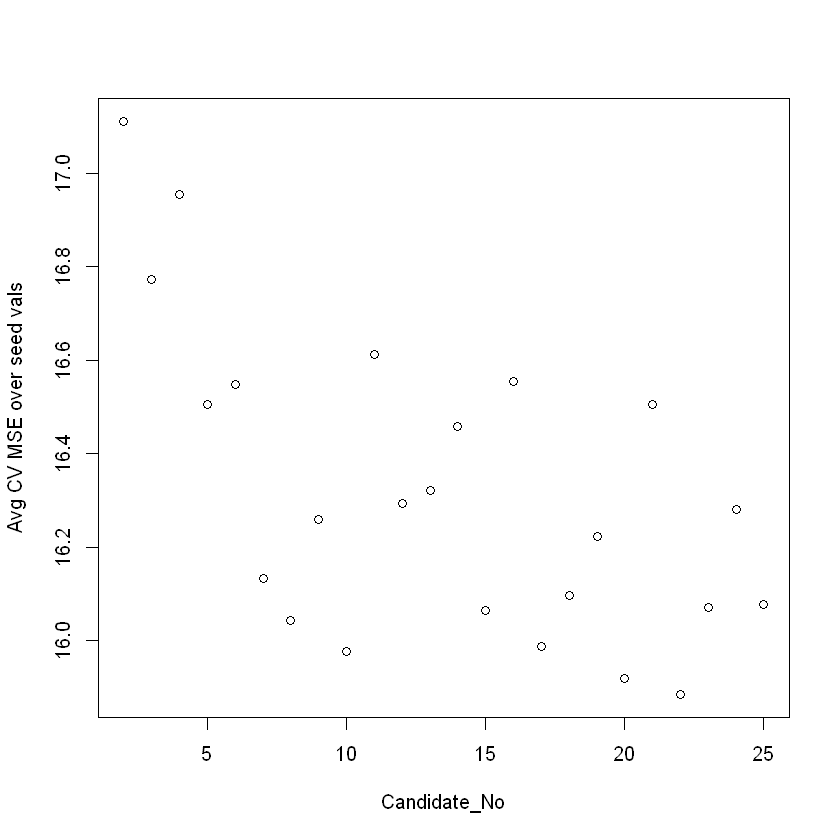

In [14]:
avg_allruns <- apply(data.frame(poly_mse_storage_mat), 1, mean)
# As the first option is uncompetitive, plot the others for clarity:
plot(2:25, avg_allruns[2:25], xlab="Candidate_No", ylab="Avg CV MSE over seed vals")

In [15]:
which.min(avg_allruns)
# Again, the 22nd candidate is optimal, which corresponds to (5,2) for orders of polyomials in (displacement, horsepower)
# expand.grid(1:5, 1:5)

[1] 22

In [16]:
# Nonlinear method 2: normal splines via GAMs.
# For normal splines 1-5 intervals for each of the two feature vars, I will loop through and evaluate the CV error
# of each candidate model:
# One approach would be to CV over the possible choices for K in K-fold CV.  However, for simplicity, I will
# iterate over 10 choices of seed with 10-fold CV, and take the indicated optimal there.
# Parms:
max_deg_sp <- 5
num_runs_sp <- 10
# Allocate 2D array to hold results from all the runs:
poly_mse_storage_mat_sp <- matrix(0, nrow=max_deg_sp^2, ncol=num_runs_sp)
for (k in 1:num_runs_sp)
{
    set.seed(k)
    for (i in 1:max_deg_sp)
    {
        for (j in 1:max_deg_sp)
        {
           model <- glm(mpg ~ ns(displacement,i) + ns(horsepower,j), data=Auto) 
           poly_mse_storage_mat_sp[max_deg_sp*(i-1)+j, k] <-  cv.glm(data=Auto, glmfit=model, K=10)$delta[1]
           # I was using this to troubleshoot previously: print(poly_mse_storage_mat)
        }
    }
}

In [17]:
# Let's look at the output matrix:
head(poly_mse_storage_mat_sp, 3)
nrow(poly_mse_storage_mat_sp)
ncol(poly_mse_storage_mat_sp)
# Each column = one choice of seed, each row in a col is one combo of powers of the spline.

20.66342,20.78089,20.84346,20.68366,20.78956,20.82469,21.01419,20.97403,20.84403,20.60274
16.85211,16.70982,16.55828,16.80506,16.89120,16.82239,17.09357,16.57273,16.80019,16.88985
16.71319,16.78338,16.73214,16.59386,16.62768,16.77334,16.59078,16.68769,16.58149,16.89072


[1] 25

[1] 10

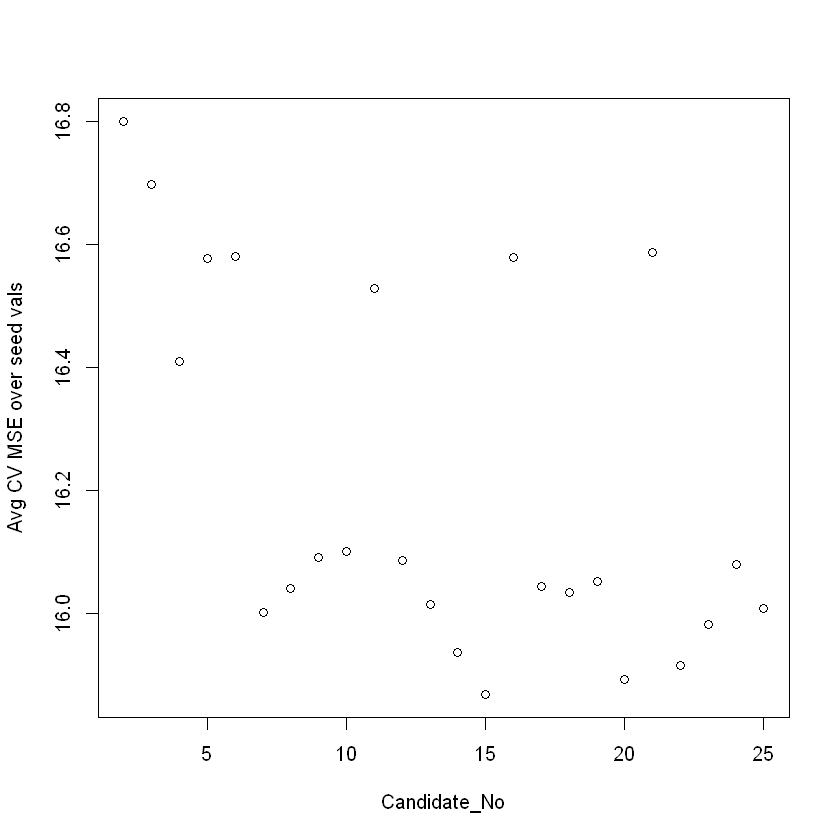

In [18]:
avg_allruns_splines <- apply(data.frame(poly_mse_storage_mat_sp), 1, mean)
# As the first option is uncompetitive, plot the others for clarity:
plot(2:25, avg_allruns_splines[2:25], xlab="Candidate_No", ylab="Avg CV MSE over seed vals")

In [19]:
which.min(avg_allruns_splines)
# print(min(avg_allruns_splines))
# Here the 15th candidate is optimal, which corresponds to (3,5) for intervals in (displacement, horsepower)

[1] 15

[1] 20.80207 15.88371 15.86779


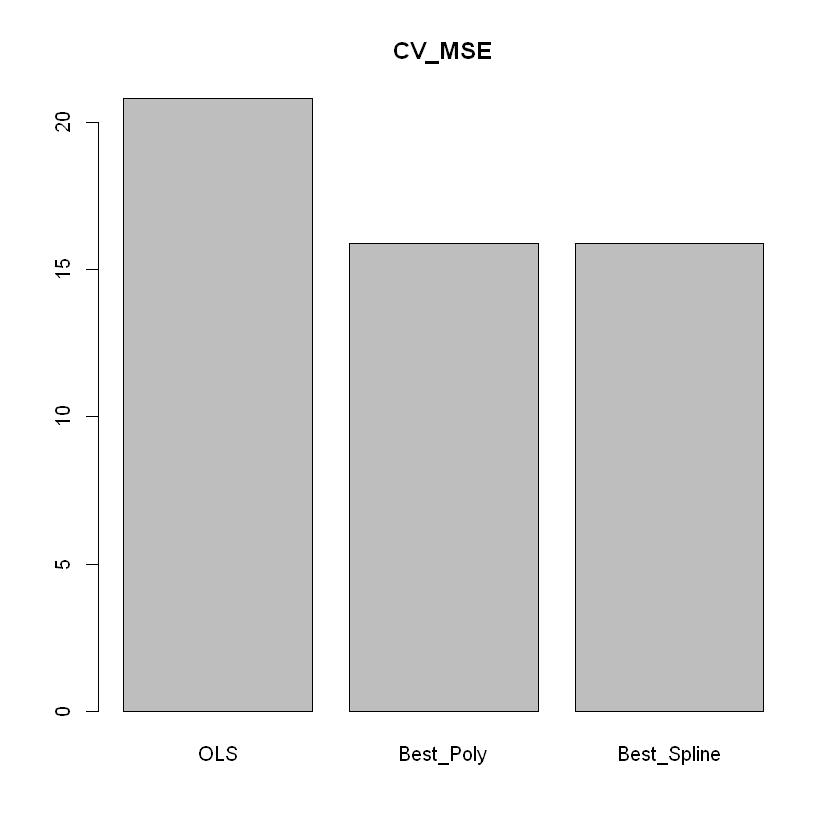

In [20]:
print(c(ols_error, avg_allruns[22], avg_allruns_splines[15]))
# This suggests that the optimal spline produces a slightly better result than the optimal polynomial solution, which are
# both significantly superior to the OLS solution.
lab <- c("OLS", "Best_Poly", "Best_Spline")
barplot(c(ols_error, avg_allruns[22], avg_allruns_splines[15]), main="CV_MSE", names.arg=lab)

In [21]:
# One further informative plot to justify the non-linear patterns that I see in the data are the statistical significance
# of the 2nd order terms seen in the model:
ip1 <- lm(mpg~displacement+I(displacement^2)+horsepower+I(horsepower^2))
summary(ip1)
# Below, both t-stats of the second order terms are >2 and p-values are less than 0.01, suggesting
# justification for inclusion of the second order terms incremental to the presence of first-order terms.


Call:
lm(formula = mpg ~ displacement + I(displacement^2) + horsepower + 
    I(horsepower^2))

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0145  -2.2646  -0.4358   2.2453  16.4228 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        5.288e+01  1.721e+00  30.722  < 2e-16 ***
displacement      -9.954e-02  1.451e-02  -6.860 2.74e-11 ***
I(displacement^2)  1.566e-04  3.295e-05   4.751 2.85e-06 ***
horsepower        -2.344e-01  4.021e-02  -5.829 1.18e-08 ***
I(horsepower^2)    5.466e-04  1.607e-04   3.403 0.000736 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.987 on 387 degrees of freedom
Multiple R-squared:  0.7418,	Adjusted R-squared:  0.7391 
F-statistic: 277.9 on 4 and 387 DF,  p-value: < 2.2e-16


In [22]:
# A second further informative plot will simply be a plot of each of a second degree and linear polynomial fit
# for each variable to the data to qualitatively see the improved fit from just a second order term.
disp_first <- lm(mpg~displacement, data=Auto)
disp_second <- lm(mpg~displacement+I(displacement^2), data=Auto)
horsepower_first <- lm(mpg~horsepower, data=Auto)
horsepower_second <- lm(mpg~horsepower+I(horsepower^2), data=Auto)

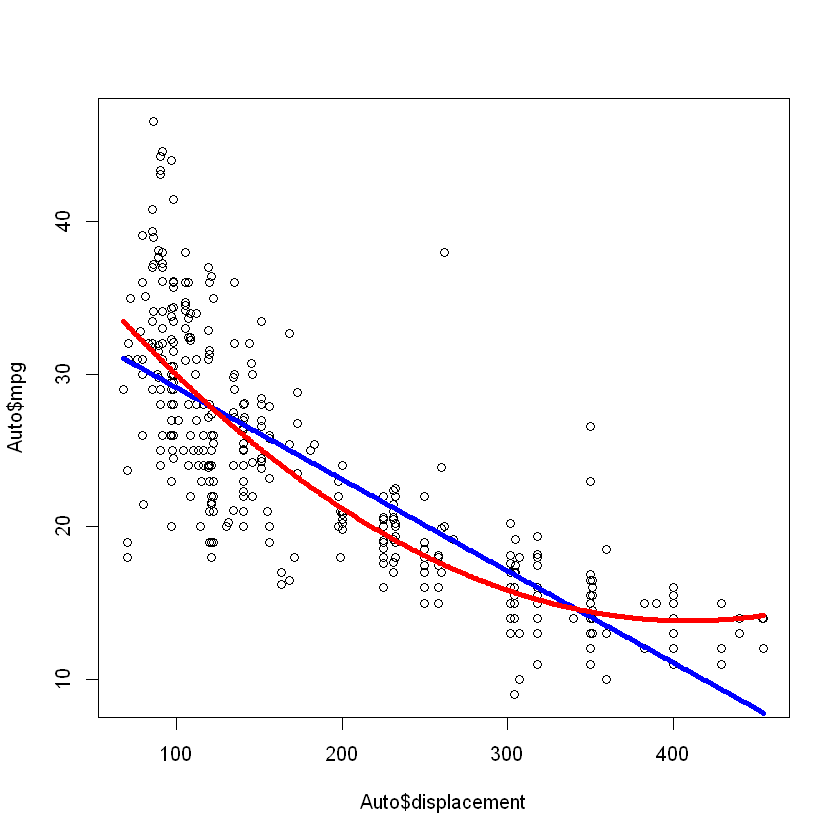

In [43]:
# Displacement plot:
d_range <- range(displacement)
d_grid <- seq(from=d_range[1], to=d_range[2])
d_pred <- predict(disp_first, newdata=data.frame(displacement=d_grid))
d_pred2 <- predict(disp_second, newdata=data.frame(displacement=d_grid))
plot(Auto$displacement, Auto$mpg)
lines(d_grid, d_pred, lwd=4, col="blue")
lines(d_grid, d_pred2, lwd=4, col="red")
# Clearly the quadratic curve fits better in the left and right tails, and thus qualitatively provides a better fit.

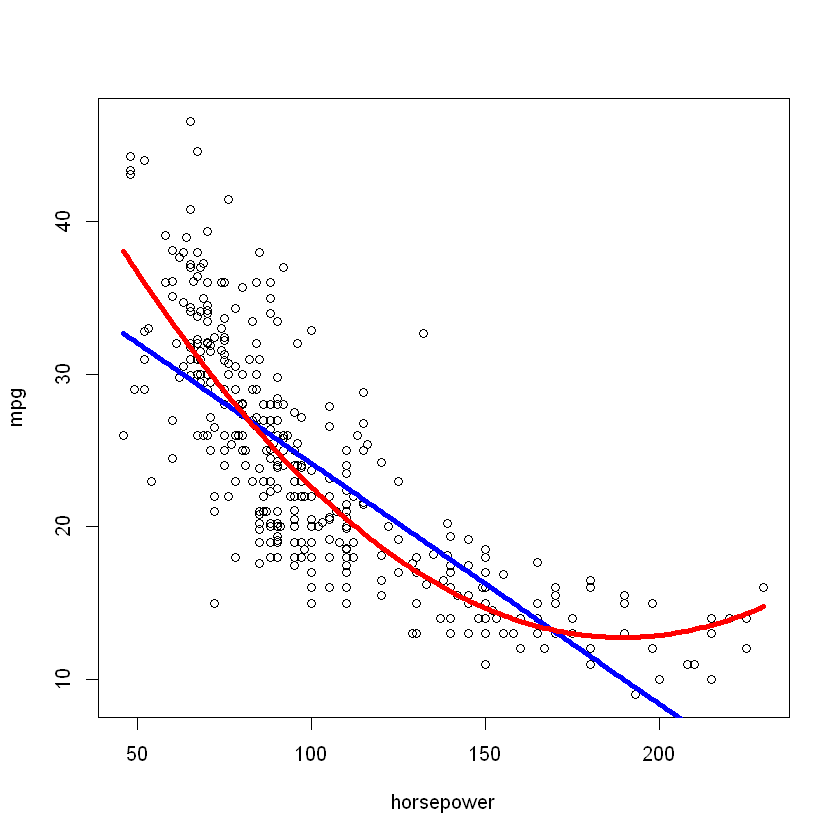

In [50]:
# Horsepower plot:
h_range <- range(horsepower)
h_grid <- seq(from=h_range[1], to=h_range[2])
h_pred <- predict(horsepower_first, newdata=data.frame(horsepower=h_grid))
h_pred2 <- predict(horsepower_second, newdata=data.frame(horsepower=h_grid))
plot(horsepower, mpg)
lines(h_grid, h_pred, lwd=4, col="blue")
lines(h_grid, h_pred2, lwd=4, col="red")
# Clearly the quadratic curve fits better in the left and right tails, and thus qualitatively provides a better fit.